In this notedbook I

In [3]:
%load_ext autoreload
%autoreload 2
#%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import cv2
import pickle
import collections
import seaborn as sns
import glob
from matplotlib.pyplot import *
from additive.utility import *
from pathos.multiprocessing import ProcessingPool, ThreadingPool
from os.path import basename, splitext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, plot_title="", cbarlabel="", color_bar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = None
    if color_bar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_title(plot_title)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [5]:
def separate_outliers(x, t=1.5):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    m = np.median(x)
    iqr = q3-q1
    outliers = (x < q1-t*iqr) | (x>q3+t*iqr)
    return x[~outliers], x[outliers]

In [6]:
def get_global_stats(df):
    #average neighborhood size
    x, xp = separate_outliers(df.end-df.beg)
    x, xp = separate_outliers(x)
    boxplot(x)
def q1(x):
    return np.percentile(x, 25)
def q3(x):
    return np.percentile(x, 75)
def p95(x):
    return np.percentile(x, 95)
def p5(x):
    return np.percentile(x, 5)


In [7]:
def p(n):
    def pp(x):
        return np.percentile(x, n)
    return pp

In [8]:
def get_all_circles(rotated):
    allCircles = []
    for i, profile in enumerate(rotated):
        _kernel_size = int(np.percentile(get_cut_points(profile, profile.mean()), 25))
        #print("kernel size param %r"%_kernel_size)
        x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                             profile,
                                                             kernel_size_param=_kernel_size,
                                                             same_scale=True, verbose=False)       
        if i%300==0:
            draw_circles(x, y, circles)
            show()
        allCircles.append(circles)
    return allCircles

In [9]:
columns = ['profile'] + list(Circle._fields)
functions = set()
circle_functions = set()
def feature(fun):
    functions.add(fun.__name__)
    return fun

def circle_feature(fun):
    circle_functions.add(fun.__name__)
    return fun

def log(s):
    print("[*] %s"%s)
    
def p(n):
    def pp(x):
        return np.percentile(x, n)
    return pp

profile, beg, end, index, h, cx, cy, r =  'profile beg end index h cx cy r'.split()
#stats = df[[profile, r]].groupby(profile).aggregate(['mean', 'median', 'std', p(5)])
#smalles_5percent = df.apply(lambda x: x.r < stats.r.pp.loc[x.profile], axis=1)

class Features:
    circle_statistics = None
    statistics = None
    circles = None
    exceptions = []
    def __init__(self, x):
        log('Starting...')
        self.x = np.ma.array(x, mask=x<x.mean(axis=1, keepdims=True)-3*x.std(axis=1, keepdims=True))
        self.kernel_sizes = [int(np.percentile(get_cut_points(profile, profile.mean()), 25)) for profile in self.x]
        log('Kernel sizes extracted')
        self.local_minima = [get_local_minima_2d(profile, kernel_size, mn=-1) for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local minima extracted')
        self.local_maxima = [get_local_minima_2d(-profile, kernel_size) for profile, kernel_size in zip(self.x, self.kernel_sizes)]
        log('Local maxima extracted')
 
    @feature
    def ra(self):
        return np.mean(np.abs(self.x-np.mean(self.x, axis=1, keepdims=True)), axis=1)

    @feature
    def rq(self):
        return np.sqrt(np.mean((self.x-np.mean(self.x, axis=1, keepdims=True))**2, axis=1))


    @feature
    def rv(self):
        return np.max(self.x-np.mean(self.x, axis=1, keepdims=True), axis=1)

    @feature
    def rz(self):
        return -np.min(self.x - np.mean(self.x, axis=1, keepdims=True), axis=1)

    @feature
    def r10_iso(self):
        return np.array([np.mean(np.sort(self.x[n][self.local_maxima[n]])[:10] ) for n in range(len(self.x))]) - \
            np.array([np.mean(np.sort(self.x[n][self.local_minima[n]])[-10:]) for n in range(len(self.x))])
    
    def get_all_circles(self):
        allCircles = []
        for i, profile in enumerate(self.x):
            try:
                x, y, der1, der2, local_minima_2d, circles = extract_circles(np.arange(len(profile)), 
                                                                     profile,
                                                                     kernel_size_param=self.kernel_sizes[i],
                                                                     same_scale=True, verbose=False)       
                if i%500==0:
                    log("Finished extracting circles from profile %5d/%5d"%(i, len(self.x)))
                allCircles.append(circles)
            except Exception as e:
                self.exceptions.append(["Exception occurred for profile %d"])
        self.circles = pd.DataFrame(((i, *circle) for i, circles in enumerate(allCircles) for circle in circles), columns=columns)   
        return self
    
    @circle_feature
    def rho(self):
        if self.circles is None:
            self.get_all_circles()
        return self.circles[['profile', 'r']].groupby('profile').aggregate('mean')
    
    @circle_feature
    def rho95(self):
        if self.circles is None:
            self.get_all_circles()       
        mardas = self.circles[['profile', 'r']].groupby('profile').aggregate(p(5))
        return self.circles[self.circles.apply(lambda x: x.r < mardas.r.loc[x.profile], axis=1)][['profile', 'r']].groupby('profile').aggregate('mean')
       
    def run_all_tests(self):
        log('Starting to run all tests.')
        self.run_all_rhos()
        return self.run_all_non_rhos()
    
    def run_all_non_rhos(self):
        log('Starting to get global properties')
        if self.statistics is None:
            self.statistics = pd.DataFrame({name: getattr(self, name)() for name in functions})
        return self
    
    def run_all_rhos(self):
        log('Starting to get global properties')
        if self.circle_statistics is None:
            circle_statistics = {name: getattr(self, name)() for name in circle_functions}
        self.circle_statistics = pd.concat((x for x in circle_statistics.values()), axis=1)
        self.circle_statistics.columns = circle_statistics.keys()
    #self.circle_statistics = {name: getattr(self, name)() for name in circle_functions}
        return self
        

#GlobalFeatures = collections.namedtuple('GlobalFeatures', functions)

In [8]:
def random_sub_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(ratio*w), int(ratio*h)
    x, y = np.random.randint(max(1,w-ww)), np.random.randint(max(1,h-hh))
    return img[x:x+ww, y:y+hh]

def middle_sub_image(img, ratio=.5):
    w, h = img.shape
    mw, mh = w//2, h//2
    ww, hh = int(ratio*w), int(ratio*h)
    x, y = np.random.randint(max(1,w-ww)), np.random.randint(max(1,h-hh))
    return img[x:x+ww, y:y+hh]


def random_sub_length_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w), int(ratio*h)
    x, y = 0, np.random.randint(max(1,h-hh))
    #print(x, y)
    return img[:, y:y+hh]

def random_sub_width_image(img, ratio=.5):
    w, h = img.shape
    ww, hh = int(w*h), int(ratio)
    x, y = np.random.randint(max(1,w-ww)), 0
    return img[x:x+ww, :]

def random_sub_profile_image(img, ratio=.5):
    return img[np.random.rand(len(img))<ratio]

In [9]:
images_mapper = {
#          'Normal': lambda x:x, 
#          'Smoothed': lambda x: cv2.pyrUp(cv2.pyrDown((x))),
#          '50% area rotate': lambda x: align_image(random_sub_image(x)),
#          '50% area tilt': lambda x: adjust_tilt(random_sub_image(x)),
          '50% area': lambda x: random_sub_image(x, .5),
#          '25% area': lambda x: random_sub_image(x, .25),
    
#          '50% length': lambda x: random_sub_length_image(x, .5),
#          '25% length': lambda x: random_sub_length_image(x, .25),
#          '50% length rotate': lambda x: align_image(random_sub_length_image(x)),
#          '50% length tilt': lambda x: adjust_tilt(random_sub_length_image(x)),
#          '50% width': lambda x: random_sub_width_image(x),
#          '25% width': lambda x: random_sub_width_image(x, .25),
#          '50% width tilt': lambda x: adjust_tilt(random_sub_width_image(x)),
#          '50% random': lambda x: random_sub_profile_image(x, .50),
#          '25% random': lambda x: random_sub_profile_image(x, .25),
#          'Rotated': lambda x: align_image(x),
#          'Tilted': lambda x: adjust_tilt(x),
#          'Tilted & Rotated': lambda x: adjust_tilt(align_image(x))
                }

In [3]:
from imports import *
file_names = set(glob.glob('/home/ben_rasoolov/additive_project/data/dataset/*_3d.np'))
file_names
#with ThreadingPool(2) as t:
#    stats_list = t.map(get_all_stats, file_names)
#stats_list = get_all_stats(file_names[0])

set()

In [11]:
from os.path import splitext
def mute():
    sys.stdout = open(os.devnull, 'w')  
def foo(args):
    (k, f), x = args
    return (k, f(x))
def get_all_stats(file_name):
    base_name, extension = splitext(file_name)
    with open(file_name, 'rb') as f:
        img = pickle.load(f)
    rescaled_image = rescale_image(img, image_info[splitext(basename(file_name))[0]])
    images = dict(foo(x) for x in zip(images_mapper.items(), [rescaled_image]*len(images_mapper)))
#    with ProcessingPool(len(images)) as pool:
#        images_features = pool.map(Features, images.values())
#    with ProcessingPool(len(images)) as pool:
#        images_features = pool.map(lambda x: x.run_all_tests(), images_features)
    images_features = [Features(image) for image in images.values()]
    images_features = [x.run_all_tests() for x in images_features]
    with open(base_name+'.features', 'wb') as f:
        pickle.dump(images_features, f)
    return True
#with ProcessingPool(len(file_names)) as pool:
#    result = pool.amap(get_all_stats, file_names)

In [12]:
def read_pickle(f_name):
    with open(f_name, 'rb') as f:
        df = pickle.load(f)
    return df

In [13]:
import os
#stats = {name: feature[0].statistics for name, feature in zip(file_names, result)}
file_names = set(glob.glob('~//*_3d.features')) - {'dataset/v06_T2_R_3d.features'}
#stats = {f_name:{k:feature.statistics for k, feature in zip(images_mapper, read_pickle(f_name))} for f_name in file_names}
print(len(file_names))
with ProcessingPool(3) as t:
    stats = dict(t.map(lambda f_name: (f_name,{k:feature.statistics for k, feature in zip(images_mapper, read_pickle(f_name))}), file_names))

23


Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
    self.run()
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/queues.py", line 337, in get
    with self._rlock:
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/bzr0014/anaconda3/envs/tf2/lib/python3.6/site-packages/multiprocess/process.py", line 258, in _bootstrap
   

In [14]:
name_dict = {'ra':"$R_a$", 'rq':"$R_q$", 'rv':"$R_v$", 'rz':"$R_z$", 'r10_iso':"$R_{10(ISO)}$"}
names = images_mapper.keys() - set('50% area rotate; 50% area tilt; 50% length tilt; 50% width tilt; 50% length rotate; 50% length tilt'.split('; '))
statistics = ['mean']
data = pd.DataFrame(
    [(file_name, name_dict[column], name, statistic, stat[name][column].describe()[statistic])
     for file_name, stat in stats.items()
     for i,name in enumerate(names) 
     for column in stat[name].columns
     for statistic in statistics],
    columns=["File Name", 'Measure', 'Variation', 'Statistics', 'Statistic Value($\mu m$)'])

In [15]:
data['File Name'] = data['File Name'].apply(lambda x: splitext(basename(x))[0])

In [16]:
#sns.set_palette("deep")
#ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='File Name', row='Statistics')
#savefig('global_measure_comparison_files_vs_files.svg')

In [17]:
data['Part Name'] = data['File Name'].str[:3]

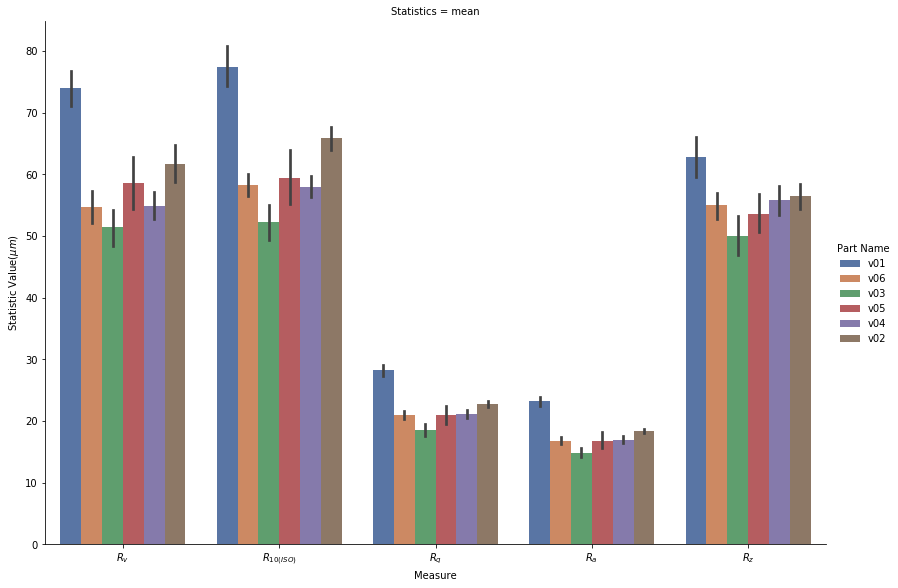

In [18]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Part Name', row='Statistics')
#savefig('global_measure_comparison_files_vs_files.svg')

In [19]:
ls *svg

alignment_fix.svg
global_measure_comparison_500x_vs_1000x.svg
global_measure_comparison_files_vs_files.svg
global_measure_comparison_normal_vs_smoothed.svg
global_measure_comparison.svg
global_measure_comparison_variation_vs_varation.svg
hypthesis_test_variation_vs_variation.svg
local_measure_comparison_500x_vs_1000x.svg
local_measure_comparison_files_vs_files.svg
local_measure_comparison_normal_vs_smoothed.svg
local_measure_comparison_parts_vs_parts.svg
local_measure_comparison_variation_vs_variation.svg
variation_comparison.svg


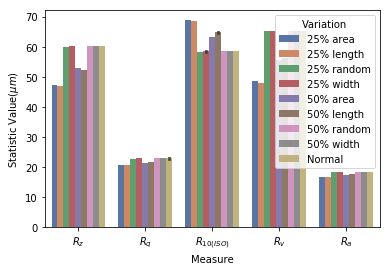

In [20]:
sns.set_palette("deep")
ax = sns.barplot(data=data.sort_values("Variation"), 
                 x='Measure', y='Statistic Value($\mu m$)', hue='Variation', ci=.95)

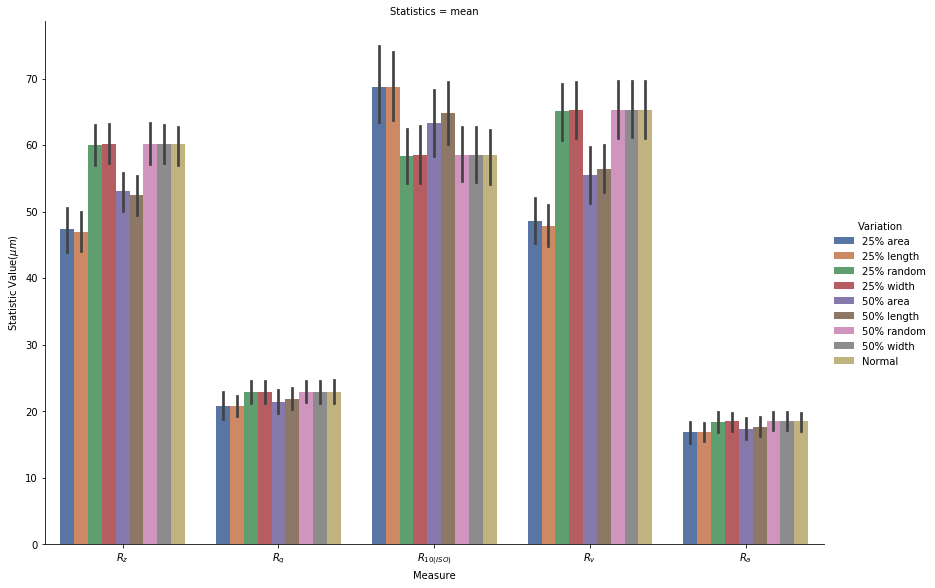

In [21]:
sns.set_palette("deep")
ax = sns.catplot(data=data.sort_values("Variation"), kind='bar',  height=8.27, aspect=11.7/8.27, 
                 x='Measure', y='Statistic Value($\mu m$)', hue='Variation', row='Statistics', ci=95)
savefig('global_measure_comparison_variation_vs_varation.svg')

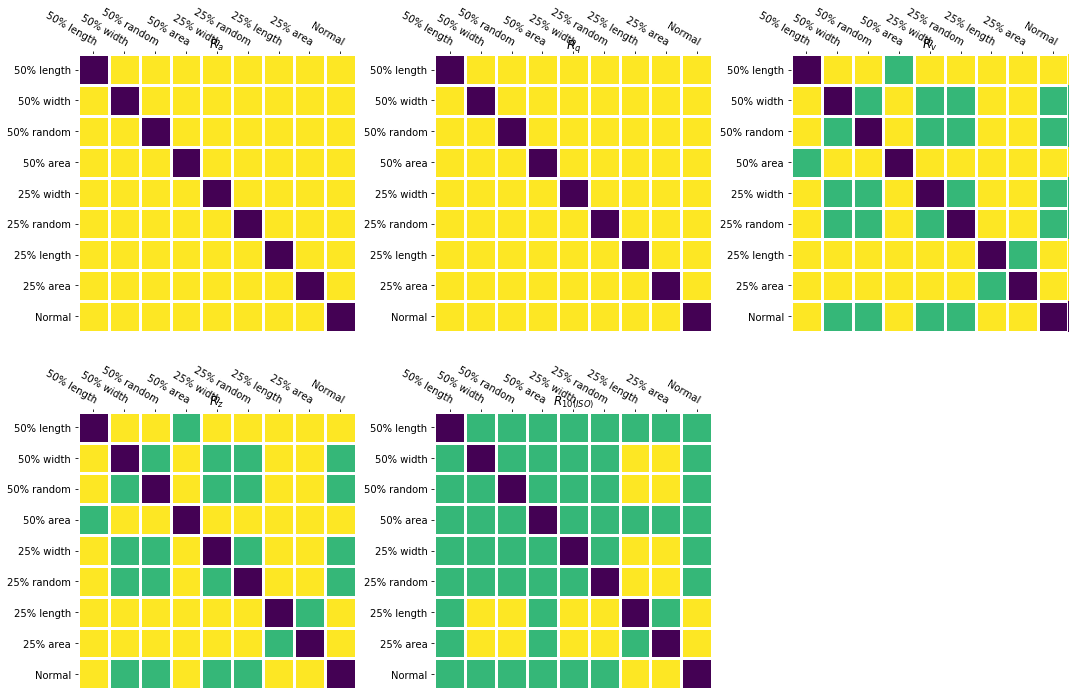

In [22]:
rcParams['figure.figsize'] = 15, 15
from scipy.stats import ttest_ind
ncols = 3
nrows = int(np.round(len(name_dict)/ncols+.99))
for index, (feature, feature_neat) in enumerate(name_dict.items(), 1):
    #ax = subplot2grid((nrows, ncols), (index//ncols, index%ncols))
    ax = subplot(nrows, ncols, index)
    d = data[(data['Statistics'] == 'mean')&(data['Measure']==name_dict[feature])]
    unique_variations = data['Variation'].unique()
    pvalues = -2*np.ones((len(unique_variations),)*2)
    for i, v1 in enumerate(unique_variations):
        d1 = d[(d['Variation'] == v1)][['Statistic Value($\mu m$)']]
        for j, v2 in enumerate(unique_variations):
            if i <= j:
                continue
            d2 = d[(d['Variation'] == v2)][['Statistic Value($\mu m$)']]
            pvalues[j, i] = pvalues[i,j]=(ttest_ind(d1, d2).pvalue[0] < .05)*1
    im, cbar = heatmap(pvalues, unique_variations, unique_variations, ax=ax, color_bar=False, 
                       plot_title=feature_neat)
tight_layout() # Or equivalently,  "plt.tight_layout()"
savefig('hypthesis_test_variation_vs_variation.svg')

In [23]:
#circle_stats = {name: mardas(feature[0]) for name, feature in zip(file_names, result)}
#circle_stats = {name: feature[0].circle_statistics for name, feature in zip(file_names, result)}
#circle_stats = {f_name:{k:feature.circle_statistics for k, feature in zip(images_mapper, read_pickle(f_name))} for f_name in file_names}
with ProcessingPool(3) as t:
    circle_stats = dict(t.map(lambda f_name: (f_name,{k:feature.circle_statistics for k, feature in zip(images_mapper, read_pickle(f_name))}), file_names))

In [24]:
name_dict = {'rho':r"$\rho$", 'rho95': r"$\rho_{95}$"}
names = images_mapper.keys() - set('50% area rotate; 50% area tilt; 50% length tilt; 50% width tilt; 50% length rotate; 50% length tilt'.split('; '))
statistics = ['mean']
data = pd.DataFrame(
    [(file_name, name_dict[column], name, statistic, stat[name][column].describe()[statistic])
     for file_name, stat in circle_stats.items()
     for i,name in enumerate(names) 
     for column in stat[name].columns
     for statistic in statistics],
    columns=["File Name", 'Measure', 'Variation', 'Statistics', 'Statistic Value($\mu m$)'])

In [25]:
#data['File Name'] = data['File Name'].apply(lambda x: x.split('/')[-1].split('_')[0][1:]+'x')
data['File Name'] = data['File Name'].apply(lambda x: splitext(basename(x))[0])
data['Part Name'] = data['File Name'].str[:3]

In [26]:
#sns.set_palette("deep")
#ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='File Name', row='Statistics')
#savefig('local_measure_comparison_files_vs_files.svg')

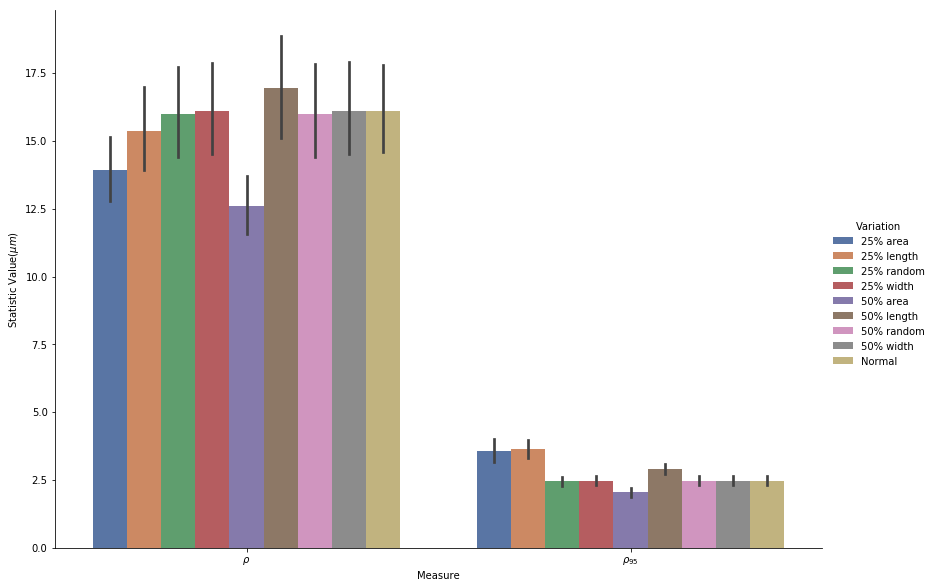

In [30]:
sns.set_palette("deep")
ax = sns.catplot(data=data.sort_values("Variation"), kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Variation', 
                 #row='File Name',
                )
savefig('local_measure_comparison_variation_vs_variation.svg')

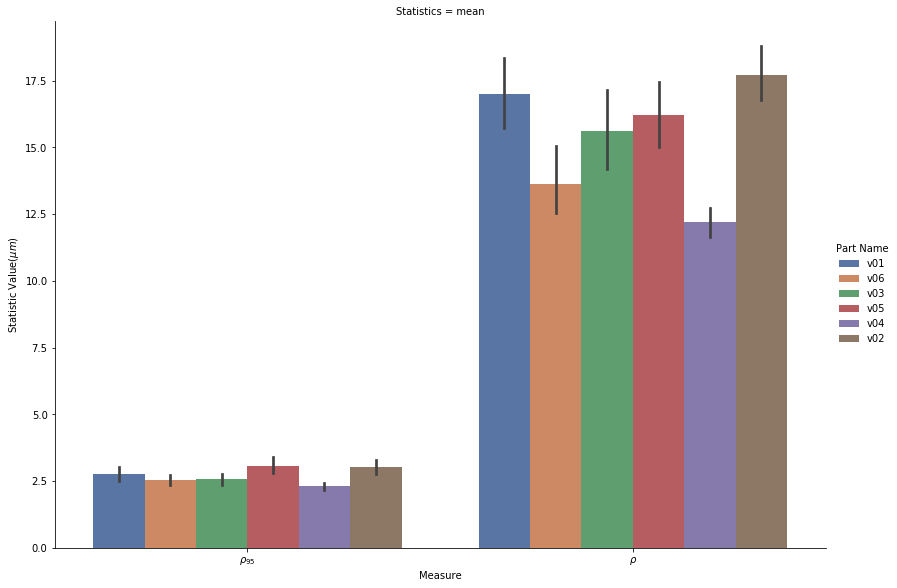

In [28]:
sns.set_palette("deep")
ax = sns.catplot(data=data, kind='bar',  height=8.27, aspect=11.7/8.27, x='Measure', y='Statistic Value($\mu m$)', hue='Part Name', row='Statistics')
savefig('local_measure_comparison_parts_vs_parts.svg')

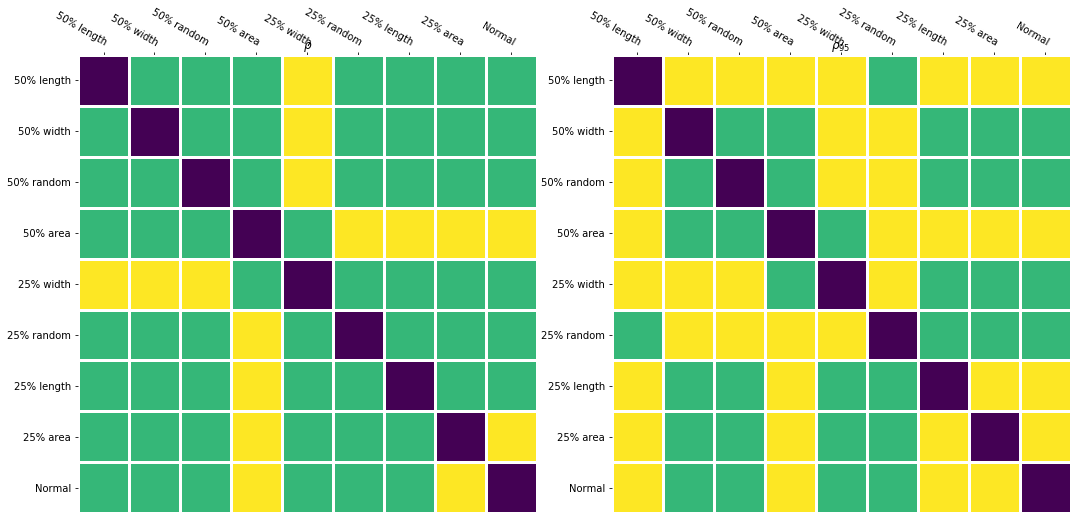

In [29]:
rcParams['figure.figsize'] = 15, 15
from scipy.stats import ttest_ind
ncols = 2
nrows = int(np.round(len(name_dict)/ncols+.99))
for index, (feature, feature_neat) in enumerate(name_dict.items(), 1):
    #ax = subplot2grid((nrows, ncols), (index//ncols, index%ncols))
    ax = subplot(nrows, ncols, index)
    d = data[(data['Statistics'] == 'mean')&(data['Measure']==name_dict[feature])]
    unique_variations = data['Variation'].unique()
    pvalues = -2*np.ones((len(unique_variations),)*2)
    for i, v1 in enumerate(sorted(unique_variations)):
        d1 = d[(d['Variation'] == v1)][['Statistic Value($\mu m$)']]
        for j, v2 in enumerate(unique_variations):
            if i <= j:
                continue
            d2 = d[(d['Variation'] == v2)][['Statistic Value($\mu m$)']]
            test_result = ttest_ind(d1, d2)
            pvalues[j, i] = pvalues[i,j]=(test_result.pvalue[0] < .05)*1
    im, cbar = heatmap(pvalues, unique_variations, unique_variations, ax=ax, color_bar=False, 
                       plot_title=feature_neat)
tight_layout() # Or equivalently,  "plt.tight_layout()"

In [117]:
sorted(unique_variations)

['25% area',
 '25% length',
 '25% random',
 '25% width',
 '50% area',
 '50% length',
 '50% random',
 '50% width',
 'Normal']

In [44]:
with open('dataset/v06_T2_L_3d.df', 'rb') as f:
    df = pickle.load(f)

In [47]:
df

,profile,beg,end,index,h,cx,cy,r,x_mean,x_std,y_mean,y_std
0,46,2203,2210,2206,-1.000000,2194.796611,22.109461,19.687603,0,1,0,1
1,54,2189,2208,2198,3.172577,2206.381818,19.605110,6.734842,0,1,0,1
2,62,1944,1971,1957,25.959323,1998.040732,38.777493,35.572210,0,1,0,1
3,63,1942,1971,1956,26.136857,1999.326468,42.321788,39.096017,0,1,0,1
4,64,2118,2163,2140,3.904924,2181.234452,23.172025,21.999485,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
133225,7240,2639,2648,2643,4.258624,2647.401260,7.056905,4.129604,0,1,0,1
133226,7241,384,399,391,4.690265,396.678440,9.366167,4.356325,0,1,0,1
133227,7241,1976,1987,1981,1.999238,1986.464006,19.626855,18.412730,0,1,0,1
133228,7241,2639,2648,2643,3.775918,2647.738149,6.651628,4.488892,0,1,0,1


In [48]:
with open('dataset/v06_T1_R_3d.features', 'rb') as f:
    image = pickle.load(f)

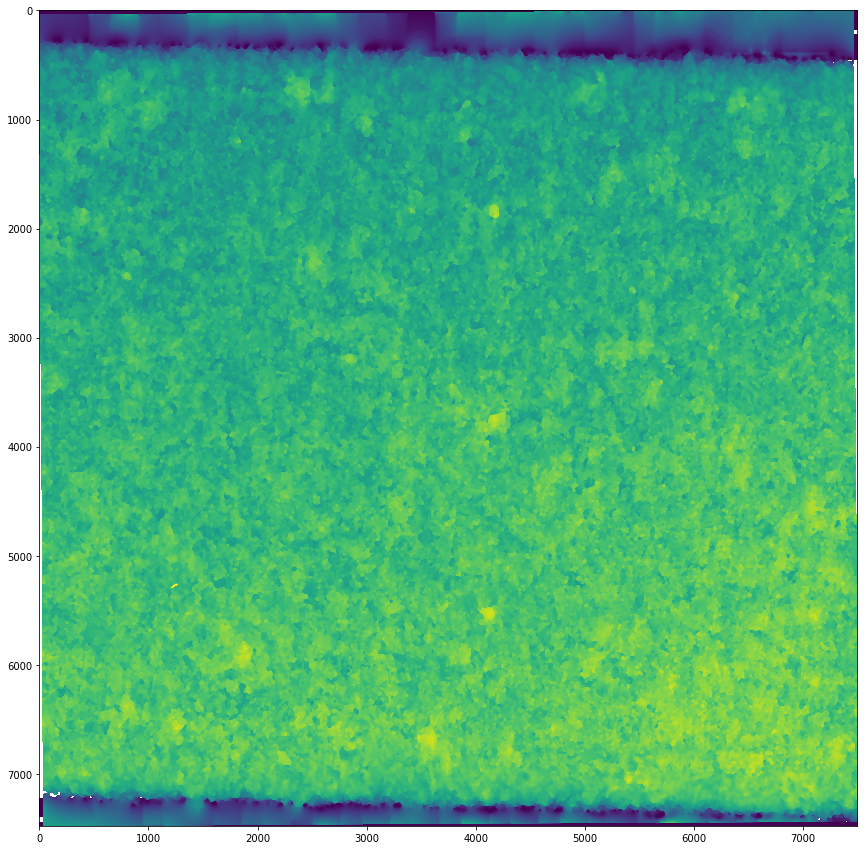

In [53]:
imshow(image[0].x)

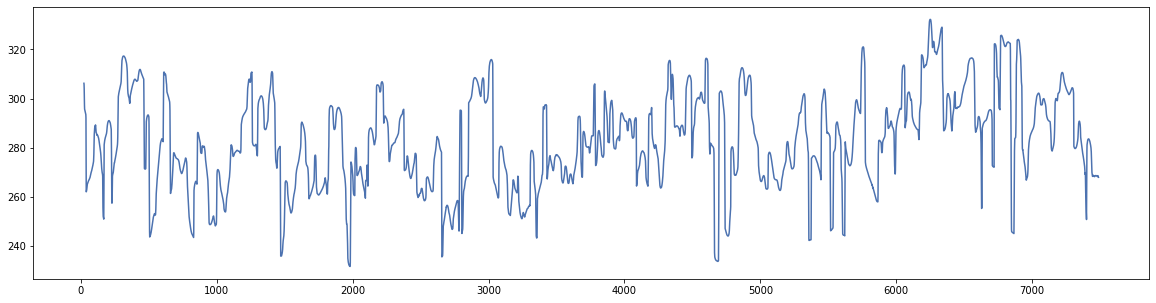

In [58]:
rcParams['figure.figsize'] = 20, 5
plot(image[0].x[5000])

In [24]:
ls /home/bzr0014/tmp/additive/

11_johns_new_data.ipynb   image_stitch.ipynb
3d/                       john_new_data/
3d_valley_analysis.ipynb  kraken_data/
4_in_1_1.png              local_minima/
4_in_1_2.png              multi_threading_test.ipynb
4_in_1_3.png              new/
4_in_1.png                newest/
As-Built/                 __pycache__/
autoencoder.h5            redo.ipynb
codes.zip                 setup.exe
convert_data-Copy1.ipynb  Untitled.ipynb
convert_data-Copy2.ipynb  utility.py
convert_data.ipynb        utility.py.bak
dataset/                  valleys.png
draft.ipynb               Vanila_neural_net-v4.ipynb
experiment_03/            VHX_CommSoft_Ver_3_0_0_116.zip
features.py


In [40]:
files = glob.glob("dataset/*features")
global_stat = {}
for file in files:
    x = joblib.load(file)
    out[file] = dict(zip(images_mapper, [t.statistics for t in x]))

KeyboardInterrupt: 

In [39]:
files = glob.glob("dataset/v*.df")
circle_stats = {}
for file in files:
    x = joblib.load(file)
    circle_stats[file] = x

,profile,beg,end,index,h,cx,cy,r,x_mean,x_std,y_mean,y_std
0,51,4884,4947,4915,11.862759,4943.707871,37.921588,27.009307,0,1,0,1
1,52,4884,4947,4915,11.847449,4943.732735,37.819968,26.930972,0,1,0,1
2,53,4884,4947,4915,11.832186,4943.759206,37.720501,26.855279,0,1,0,1
3,54,4882,4947,4914,11.826776,4941.020853,44.063200,32.824701,0,1,0,1
4,55,4699,4728,4713,55.381340,4749.816246,30.786161,19.581991,0,1,0,1
5,55,4882,4947,4914,11.811482,4941.062043,44.011216,32.797020,0,1,0,1
6,56,4699,4728,4713,54.900195,4749.810488,31.082291,19.802499,0,1,0,1
7,56,4882,4947,4914,11.795898,4941.094138,43.970644,32.781369,0,1,0,1
8,57,4699,4728,4713,54.430432,4750.509969,31.881012,20.560131,0,1,0,1
9,57,4879,4946,4912,11.802464,4942.800140,38.328745,27.710950,0,1,0,1


In [32]:
x[0].

,rho95,rho
profile,,
47,32.315242,33.384680
48,32.335783,33.544765
49,32.361450,33.707784
50,19.194799,27.328954
51,33.377393,35.833801
52,34.227663,36.426222
53,26.835118,33.323615
54,27.409226,33.636716
55,27.342322,33.717415


In [11]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'